In [233]:
import pandas as pd
pd.set_option('display.max_colwidth', 1000)
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import PolynomialFeatures

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import RFE
from sklearn.model_selection import GridSearchCV, StratifiedKFold, KFold
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from scipy import stats

import category_encoders as ce

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler

from scipy.stats import mannwhitneyu

# import pingouin as pg

from sklearn.metrics import confusion_matrix, classification_report, f1_score, recall_score, precision_score, plot_confusion_matrix, plot_roc_curve, roc_curve

# A) Import Data

In [234]:
nba_players = pd.read_csv('data/nba_players.csv')
new_players = pd.read_csv('data/new_players.csv')

In [235]:
nba_players.head(2)

,Unnamed: 0,Unnamed: 0.1,player_name,team_abbreviation,age,player_height,player_weight,college,country,draft_year,draft_round,draft_number,gp,pts,reb,ast,net_rating,oreb_pct,dreb_pct,usg_pct,ts_pct,ast_pct,season,potential_player
0,0,0,Dennis Rodman,CHI,36.0,198.12,99.79024,Southeastern Oklahoma State,USA,1986,2,27,55,5.7,16.1,3.1,16.1,0.186,0.323,0.100,0.479,0.113,1996-97,0
1,1,1,Dwayne Schintzius,LAC,28.0,215.90,117.93392,Florida,USA,1990,1,24,15,2.3,1.5,0.3,12.3,0.078,0.151,0.175,0.430,0.048,1996-97,0


In [236]:
new_players.sample(2)

,Unnamed: 0,player_id,age,player_height,player_weight,college,country,gp,pts,reb,ast,net_rating,oreb_pct,dreb_pct,usg_pct,ts_pct,ast_pct
268,268,269,33.0,198.12,90.71840,California-Santa Barbara,USA,1,0.0,1.0,1.0,-31.2,0.000,0.250,0.154,0.000,0.333
188,188,189,29.0,198.12,97.52228,Ohio State,USA,33,21.2,3.2,2.7,3.9,0.024,0.087,0.255,0.566,0.121


#### Features pada data nba_players dan new_players
- jumlah features pada data nba_players (23) lebih banyak dari data new_players (17).
- karena pembuatan model akan menggunakan data nba_players, maka features yang akan dipakai akan disesuaikan dengan jumlah features pada data new_players berdasarkan nama features yang ada
- selama pembuatan model, data yang akan dipakai adalah data nba_players. 
- data new_features akan digunakan setelah best model dipilih

In [237]:
# Columns pada data nba_players
pd.set_option('max_columns', None)
pd.DataFrame(nba_players.columns).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
0,Unnamed: 0,Unnamed: 0.1,player_name,team_abbreviation,age,player_height,player_weight,college,country,draft_year,draft_round,draft_number,gp,pts,reb,ast,net_rating,oreb_pct,dreb_pct,usg_pct,ts_pct,ast_pct,season,potential_player


In [238]:
# Columns pada data new_players
pd.DataFrame(new_players.columns).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,Unnamed: 0,player_id,age,player_height,player_weight,college,country,gp,pts,reb,ast,net_rating,oreb_pct,dreb_pct,usg_pct,ts_pct,ast_pct


# B) Data Understanding

In [239]:
display(nba_players.describe())
display(nba_players.describe(include='object'))

,Unnamed: 0,Unnamed: 0.1,age,player_height,player_weight,gp,pts,reb,ast,net_rating,oreb_pct,dreb_pct,usg_pct,ts_pct,ast_pct,potential_player
count,11145.000000,11145.000000,11145.000000,11145.000000,11145.000000,11145.000000,11145.000000,11145.000000,11145.000000,11145.000000,11145.000000,11145.000000,11145.000000,11145.000000,11145.000000,11145.000000
mean,5572.000000,5572.000000,27.168686,200.812818,100.637868,52.005832,8.126487,3.560036,1.801463,-2.153899,0.055593,0.141772,0.185599,0.508099,0.131078,0.040825
std,3217.428709,3217.428709,4.344164,9.190973,12.576295,25.069495,5.935482,2.495394,1.789940,12.150611,0.043889,0.063194,0.053047,0.098879,0.095017,0.197895
min,0.000000,0.000000,18.000000,160.020000,60.327736,1.000000,0.000000,0.000000,0.000000,-200.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2786.000000,2786.000000,24.000000,195.580000,90.718400,32.000000,3.500000,1.800000,0.600000,-6.300000,0.022000,0.096000,0.150000,0.478000,0.065000,0.000000
50%,5572.000000,5572.000000,27.000000,200.660000,99.790240,58.000000,6.600000,3.000000,1.200000,-1.300000,0.043000,0.132000,0.182000,0.521000,0.102000,0.000000
75%,8358.000000,8358.000000,30.000000,208.280000,109.315672,74.000000,11.500000,4.700000,2.400000,3.200000,0.086000,0.182000,0.218000,0.557000,0.178000,0.000000
max,11144.000000,11144.000000,44.000000,231.140000,163.293120,85.000000,36.100000,16.300000,11.700000,300.000000,1.000000,1.000000,1.000000,1.500000,1.000000,1.000000


,player_name,team_abbreviation,college,country,draft_year,draft_round,draft_number,season
count,11145,11145,11145,11145,11145,11145,11145,11145
unique,2235,36,316,76,45,8,75,24
top,Vince Carter,CLE,None,USA,Undrafted,1,Undrafted,2017-18
freq,22,390,1684,9410,1942,6513,1959,540


In [240]:
nba_players.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11145 entries, 0 to 11144
Data columns (total 24 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         11145 non-null  int64  
 1   Unnamed: 0.1       11145 non-null  int64  
 2   player_name        11145 non-null  object 
 3   team_abbreviation  11145 non-null  object 
 4   age                11145 non-null  float64
 5   player_height      11145 non-null  float64
 6   player_weight      11145 non-null  float64
 7   college            11145 non-null  object 
 8   country            11145 non-null  object 
 9   draft_year         11145 non-null  object 
 10  draft_round        11145 non-null  object 
 11  draft_number       11145 non-null  object 
 12  gp                 11145 non-null  int64  
 13  pts                11145 non-null  float64
 14  reb                11145 non-null  float64
 15  ast                11145 non-null  float64
 16  net_rating         111

# C) Data Preprocessing - Soal No. 1

Berikut adalah beberapa poin yang akan dicek dalam data preprocessing. Semua proses tersebut akan dijadikan satu dalam pipeline/transformer. Dalam bagian akan ditampilkan contoh hasil preprocessing secara terpisah dari pipeline

1. checking missing values 
    - imputation
1. dropping features
    - nba_players: drop
    - new_players: drop `player_id`
1. encoding
    - binary encoding: `college` & `country`
1. scaling
    - standard scaler: "gp"
    - robust scaler: untuk feature ["pts", "reb", "ast", "net_rating", "oreb_pct", "dreb_pct", "usg_pct", "ts_pct", "ast_pct"]

### C.1) Missing Values

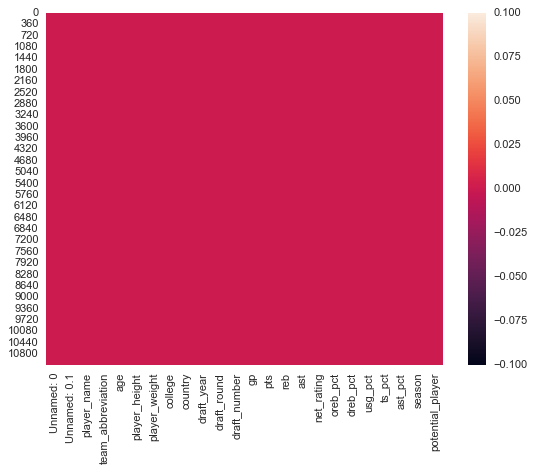

In [241]:
sns.heatmap(nba_players.isna());

In [24]:
pd.DataFrame(nba_players.isna().sum()).T

,Unnamed: 0,Unnamed: 0.1,player_name,team_abbreviation,age,player_height,player_weight,college,country,draft_year,draft_round,draft_number,gp,pts,reb,ast,net_rating,oreb_pct,dreb_pct,usg_pct,ts_pct,ast_pct,season,potential_player
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


- pada data nba_players, tidak ditemukan adanya missing values pada setiap feature
- dalam hal ini, proses imputation tidak diperlukan karena semua data sudah lengkap

### C.2) Dropping Unused Features
- dikarenakan jumlah features dan nama features dari kedua dataset tidak sesuai, maka satu atau lebih features dari masing-masing dataset akan didrop
- hal ini bertujuan supaya model dapat memprediksi data baru (new_players) sesuai features yang dimiliki

#### Features Dropping in nba_players

In [242]:
# panduan untuk drop features diambil dari nama kolom pada data new_players
new_players.columns

Index(['Unnamed: 0', 'player_id', 'age', 'player_height', 'player_weight',
       'college', 'country', 'gp', 'pts', 'reb', 'ast', 'net_rating',
       'oreb_pct', 'dreb_pct', 'usg_pct', 'ts_pct', 'ast_pct'],
      dtype='object')

In [243]:
# list nama features yang akan di drop
dropped_features = ['Unnamed: 0.1', 'team_abbreviation', 'draft_year',
       'draft_round', 'draft_number', 'season']
dropped_features


['Unnamed: 0.1',
 'team_abbreviation',
 'draft_year',
 'draft_round',
 'draft_number',
 'season']

- nama features yang akan di drop sudah didapatkan
- namun untuk sementara ini terdapat pengecualian untuk features `player_name`
- dikarenakan di data nba_players tidak ada player_id, maka untuk kebutuhan EDA, feature `player_name` masih akan tetap disimpan dan akan di drop di dalam pipeline/transformer

In [244]:
# proses features dropping
nba_players_cleaned = nba_players.drop(dropped_features, axis=1)
nba_players_cleaned.sample(2)

,Unnamed: 0,player_name,age,player_height,player_weight,college,country,gp,pts,reb,ast,net_rating,oreb_pct,dreb_pct,usg_pct,ts_pct,ast_pct,potential_player
10857,10857,Cheick Diallo,23.0,203.20,99.336648,Kansas,Mali,42,4.7,2.8,0.5,-5.6,0.06,0.213,0.165,0.687,0.079,0
567,567,Tim Breaux,27.0,200.66,97.522280,Wyoming,USA,6,1.7,0.3,0.3,1.2,0.00,0.069,0.209,0.421,0.154,0


#### Features Dropping in new_players
- untuk menyamakan dengan data yang tidak dimiliki oleh nba_players, maka feature player_id akan di drop

In [39]:
new_players_cleaned = new_players.drop('player_id', axis=1)
new_players_cleaned.sample(2)

,Unnamed: 0,age,player_height,player_weight,college,country,gp,pts,reb,ast,net_rating,oreb_pct,dreb_pct,usg_pct,ts_pct,ast_pct
412,412,30.0,203.20,97.52228,North Carolina State,USA,77,5.0,2.4,0.7,2.8,0.058,0.119,0.177,0.472,0.077
16,16,29.0,187.96,86.18248,New Mexico State,USA,72,4.7,1.5,1.8,10.4,0.037,0.079,0.178,0.461,0.178


In [245]:
# Columns pada data nba_players_cleaned
print("columns length: ", len(nba_players_cleaned.columns))
pd.DataFrame(nba_players_cleaned.columns).T

columns length:  18


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,Unnamed: 0,player_name,age,player_height,player_weight,college,country,gp,pts,reb,ast,net_rating,oreb_pct,dreb_pct,usg_pct,ts_pct,ast_pct,potential_player


In [44]:
# Columns pada data new_players_cleaned
print("columns length: ", len(new_players_cleaned.columns))
pd.DataFrame(new_players_cleaned.columns).T

columns length:  16


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,Unnamed: 0,age,player_height,player_weight,college,country,gp,pts,reb,ast,net_rating,oreb_pct,dreb_pct,usg_pct,ts_pct,ast_pct


- kedua dataset saat ini sudah memiliki features yang sama kecuali feature `player_name` dan `potential_player`
    - `player_name` akan digunakan untuk menggantikan feature `player_id` untuk keperluan mengidentifikasi data pemain satu-persatu (dalam data nba_players, terdapat pemain yang memiliki data lebih dari satu)
    - `potential_player` digunakan sebagai target label yang berfungsi sebagai ground truth dalam memprediksi pemain baru yang akan direkrut

### C.3) Encoding

In [246]:
nba_players_cleaned.describe(include='object')

,player_name,college,country
count,11145,11145,11145
unique,2235,316,76
top,Vince Carter,None,USA
freq,22,1684,9410


- data yang masih berupa object akan di encoding
- setelah melihat jumlah kelas pada features `college` dan `country` yang memiliki lebih dari 10 kelas, maka diputuskan untuk memakai strategi binary encoding supaya kolom hasil encoding tidak terlalu banyak.
- pada langkah ini hanya akan ditampilkan contoh hasil encoding, proses sebenarnya untuk modelling akan dilakukan didalam pipeline

#### Encoding pada `college`

In [247]:
binary_encoder_college = ce.BinaryEncoder(cols=['college'])
df_college_be = binary_encoder_college.fit_transform(nba_players_cleaned['college'])
df_college_be.sample(5)

C:\ProgramData\miniconda3\envs\ml_dl\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


,college_0,college_1,college_2,college_3,college_4,college_5,college_6,college_7,college_8,college_9
8196,0,0,0,1,0,0,0,1,1,0
465,0,0,1,0,0,1,1,0,0,1
3283,0,0,0,0,0,0,1,0,1,1
4565,0,0,0,0,0,0,1,0,0,1
6861,0,0,0,1,0,0,0,1,1,0


#### Encoding pada `country`

In [248]:
binary_encoder_country = ce.BinaryEncoder(cols=['country'])
df_country_be = binary_encoder_country.fit_transform(nba_players_cleaned['country'])
df_country_be.sample(5)

C:\ProgramData\miniconda3\envs\ml_dl\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


,country_0,country_1,country_2,country_3,country_4,country_5,country_6,country_7
11055,0,0,0,0,0,0,0,1
10650,0,0,0,0,0,0,0,1
8306,0,0,0,0,0,0,0,1
5360,0,0,0,0,0,0,0,1
7160,0,0,0,1,1,1,1,1


### C.4) Scaling

In [50]:
nba_players_cleaned.describe()

,Unnamed: 0,age,player_height,player_weight,gp,pts,reb,ast,net_rating,oreb_pct,dreb_pct,usg_pct,ts_pct,ast_pct,potential_player
count,11145.000000,11145.000000,11145.000000,11145.000000,11145.000000,11145.000000,11145.000000,11145.000000,11145.000000,11145.000000,11145.000000,11145.000000,11145.000000,11145.000000,11145.000000
mean,5572.000000,27.168686,200.812818,100.637868,52.005832,8.126487,3.560036,1.801463,-2.153899,0.055593,0.141772,0.185599,0.508099,0.131078,0.040825
std,3217.428709,4.344164,9.190973,12.576295,25.069495,5.935482,2.495394,1.789940,12.150611,0.043889,0.063194,0.053047,0.098879,0.095017,0.197895
min,0.000000,18.000000,160.020000,60.327736,1.000000,0.000000,0.000000,0.000000,-200.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2786.000000,24.000000,195.580000,90.718400,32.000000,3.500000,1.800000,0.600000,-6.300000,0.022000,0.096000,0.150000,0.478000,0.065000,0.000000
50%,5572.000000,27.000000,200.660000,99.790240,58.000000,6.600000,3.000000,1.200000,-1.300000,0.043000,0.132000,0.182000,0.521000,0.102000,0.000000
75%,8358.000000,30.000000,208.280000,109.315672,74.000000,11.500000,4.700000,2.400000,3.200000,0.086000,0.182000,0.218000,0.557000,0.178000,0.000000
max,11144.000000,44.000000,231.140000,163.293120,85.000000,36.100000,16.300000,11.700000,300.000000,1.000000,1.000000,1.000000,1.500000,1.000000,1.000000


C:\ProgramData\miniconda3\envs\ml_dl\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\ProgramData\miniconda3\envs\ml_dl\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\ProgramData\miniconda3\envs\ml_dl\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarnin

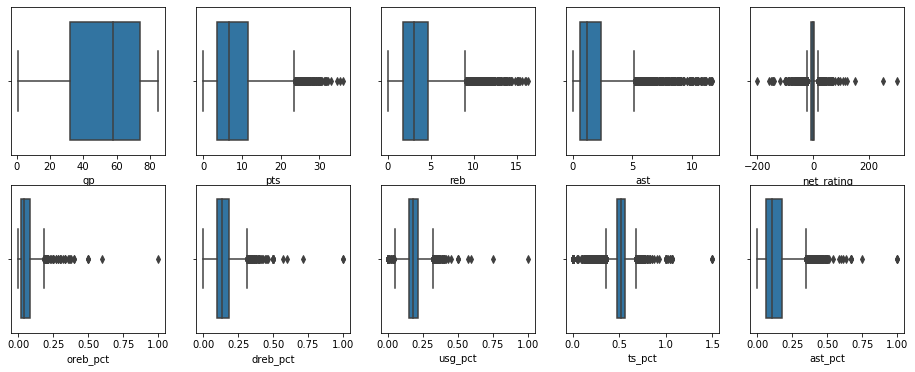

In [56]:
plt.figure(figsize=(16,6))

plt.subplot(251)
sns.boxplot(nba_players_cleaned.gp)

plt.subplot(252)
sns.boxplot(nba_players_cleaned.pts)

plt.subplot(253)
sns.boxplot(nba_players_cleaned.reb)

plt.subplot(254)
sns.boxplot(nba_players_cleaned.ast)

plt.subplot(255)
sns.boxplot(nba_players_cleaned.net_rating)

plt.subplot(256)
sns.boxplot(nba_players_cleaned.oreb_pct)

plt.subplot(257)
sns.boxplot(nba_players_cleaned.dreb_pct)

plt.subplot(258)
sns.boxplot(nba_players_cleaned.usg_pct)

plt.subplot(259)
sns.boxplot(nba_players_cleaned.ts_pct)

plt.subplot(2,5,10)
sns.boxplot(nba_players_cleaned.ast_pct)

plt.show()

- scaling akan dilakukan untuk data numeric yang berkaitan dengan statistik basket
    - standard scaler: untuk feature gp karena outlier tidak ada
    - robust scaler: untuk feature ["pts", "reb", "ast", "net_rating", "oreb_pct", "dreb_pct", "usg_pct", "ts_pct", "ast_pct"] --> karena banyak outlier dan supaya scaling nya tidak terpengaruh oleh outlier

#### standard scaler in `gp`

In [60]:
temp_gp = nba_players_cleaned[['gp']]
standard = StandardScaler()

In [61]:
temp_standard_scaler = standard.fit_transform(temp_gp)
temp_standard_scaler = pd.DataFrame(temp_standard_scaler, columns=['gp'])
temp_standard_scaler

,gp
0,0.119440
1,-1.476196
2,-1.715542
3,0.478458
4,-0.997505
...,...
11140,0.438567
11141,-1.476196
11142,-0.119905
11143,-1.276742


In [63]:
# before scaling
temp_gp

,gp
0,55
1,15
2,9
3,64
4,27
...,...
11140,63
11141,15
11142,49
11143,20


#### robust scaler in ["pts", "reb", "ast", "net_rating", "oreb_pct", "dreb_pct", "usg_pct", "ts_pct", "ast_pct"] 

In [64]:
temp_X = nba_players_cleaned[["pts", "reb", "ast", "net_rating", "oreb_pct", "dreb_pct", "usg_pct", "ts_pct", "ast_pct"]]
robust = RobustScaler()

In [66]:
temp_robust_scaler = robust.fit_transform(temp_X)
temp_robust_scaler = pd.DataFrame(temp_robust_scaler, columns=["pts", "reb", "ast", "net_rating", "oreb_pct", "dreb_pct", "usg_pct", "ts_pct", "ast_pct"])
temp_robust_scaler

,pts,reb,ast,net_rating,oreb_pct,dreb_pct,usg_pct,ts_pct,ast_pct
0,-0.1125,4.517241,1.055556,1.831579,2.234375,2.220930,-1.205882,-0.531646,0.097345
1,-0.5375,-0.517241,-0.500000,1.431579,0.546875,0.220930,-0.102941,-1.151899,-0.477876
2,-0.7250,-0.689655,-0.444444,-0.084211,0.968750,-0.348837,-1.161765,-1.835443,0.407080
3,-0.3625,-0.241379,-0.333333,-0.778947,0.265625,0.197674,-0.220588,-1.544304,-0.221239
4,-0.5250,-0.206897,-0.555556,-1.042105,1.031250,0.546512,-0.808824,1.139241,-0.548673
...,...,...,...,...,...,...,...,...,...
11140,0.3125,0.827586,-0.055556,0.621053,0.203125,0.093023,-0.676471,1.063291,-0.336283
11141,-0.6750,-0.931034,-0.611111,-0.115789,-0.390625,-0.860465,-0.264706,-0.518987,-0.610619
11142,-0.0625,0.724138,-0.055556,0.726316,-0.218750,0.988372,-0.911765,1.506329,-0.230088
11143,-0.5625,0.000000,-0.444444,-1.589474,0.656250,1.220930,-0.823529,0.000000,-0.407080


In [65]:
# before scaling
temp_X

,pts,reb,ast,net_rating,oreb_pct,dreb_pct,usg_pct,ts_pct,ast_pct
0,5.7,16.1,3.1,16.1,0.186,0.323,0.100,0.479,0.113
1,2.3,1.5,0.3,12.3,0.078,0.151,0.175,0.430,0.048
2,0.8,1.0,0.4,-2.1,0.105,0.102,0.103,0.376,0.148
3,3.7,2.3,0.6,-8.7,0.060,0.149,0.167,0.399,0.077
4,2.4,2.4,0.2,-11.2,0.109,0.179,0.127,0.611,0.040
...,...,...,...,...,...,...,...,...,...
11140,9.1,5.4,1.1,4.6,0.056,0.140,0.136,0.605,0.064
11141,1.2,0.3,0.1,-2.4,0.018,0.058,0.164,0.480,0.033
11142,6.1,5.1,1.1,5.6,0.029,0.217,0.120,0.640,0.076
11143,2.1,3.0,0.4,-16.4,0.085,0.237,0.126,0.521,0.056


# D) Visualization - Soal No. 2
minimum visualization
1. Bagaimana distribusi score antara pemain yang potential dengan yang tidak potential?
1. Bagaimana distribusi rebound antara pemain yang potential dengan yang tidak potential?
1. Bagaimana distribusi assist antara pemain yang potential dengan yang tidak potential?
1. Apakah tinggi dan berat pemain dapat mempengaruhi pemain dicap potential atau tidak?
1. Kampus mana yang paling sering menelurkan pemain-pemain potential di NBA?

### D.1) Distribusi Data Target

,potential_player
0,0.959175
1,0.040825


C:\ProgramData\miniconda3\envs\ml_dl\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


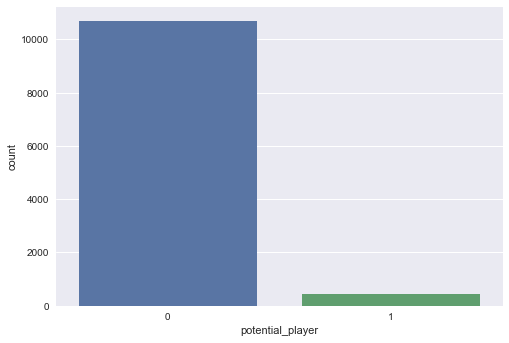

In [80]:
display(pd.DataFrame(nba_players_cleaned.potential_player.value_counts(normalize=True)))
sns.countplot(nba_players_cleaned.potential_player);

- data of `potential_player` is **imbalanced**
- there should be a special treatment to handle this issue when developing the model

### D.2) Distribusi pemain potensial dan tidak potential

In [67]:
nba_players_cleaned.head(1)

,Unnamed: 0,player_name,age,player_height,player_weight,college,country,gp,pts,reb,ast,net_rating,oreb_pct,dreb_pct,usg_pct,ts_pct,ast_pct,potential_player
0,0,Dennis Rodman,36.0,198.12,99.79024,Southeastern Oklahoma State,USA,55,5.7,16.1,3.1,16.1,0.186,0.323,0.1,0.479,0.113,0


In [69]:
temp = nba_players_cleaned[['player_name', 'potential_player']].groupby('player_name', as_index=False).sum()
temp

,player_name,potential_player
0,A.C. Green,0
1,A.J. Bramlett,0
2,A.J. Guyton,0
3,AJ Hammons,0
4,AJ Price,0
...,...,...
2230,Zion Williamson,0
2231,Zoran Dragic,0
2232,Zoran Planinic,0
2233,Zydrunas Ilgauskas,0


In [71]:
pie_data = pd.DataFrame({"status": ['non-potential', 'potential'], 
                        "quantity": [len(temp[temp['potential_player'] == 0]),
                                     len(temp[temp['potential_player'] != 0])]})

,status,quantity
0,non-potential,2102
1,potential,133


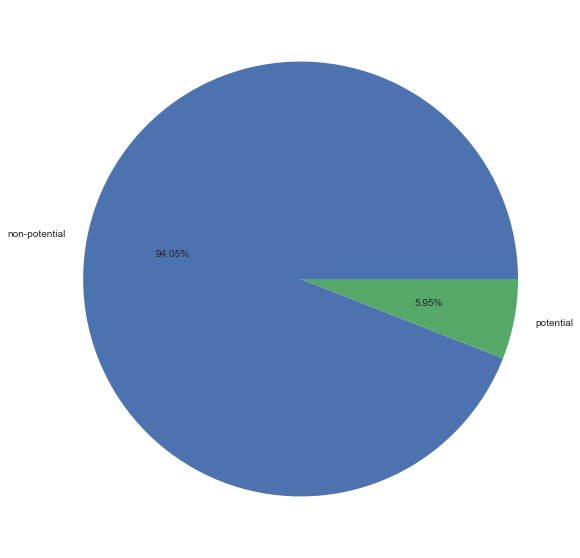

In [73]:
display(pie_data)

plt.style.use('seaborn')
fig = plt.figure(figsize=(10,10))
ax = plt.axes()

ax.pie(pie_data['quantity'], labels=pie_data['status'], autopct=lambda p:f'{p:.2f}%')

plt.show()

- identification of number of players based on name can show the following facts:
    - number of potential players: 133
    - number of non-potential players: 2102
- this fact aligns with the potential_player data distribution that there are more data of non-potential players (label **0**)

### C.3) Distribusi score pemain potential dan pemain non-potential
berdasarkan feature `pts`, `reb`, `ast`

In [91]:
nba_players_cleaned.head()

,Unnamed: 0,player_name,age,player_height,player_weight,college,country,gp,pts,reb,ast,net_rating,oreb_pct,dreb_pct,usg_pct,ts_pct,ast_pct,potential_player
0,0,Dennis Rodman,36.0,198.12,99.790240,Southeastern Oklahoma State,USA,55,5.7,16.1,3.1,16.1,0.186,0.323,0.100,0.479,0.113,0
1,1,Dwayne Schintzius,28.0,215.90,117.933920,Florida,USA,15,2.3,1.5,0.3,12.3,0.078,0.151,0.175,0.430,0.048,0
2,2,Earl Cureton,39.0,205.74,95.254320,Detroit Mercy,USA,9,0.8,1.0,0.4,-2.1,0.105,0.102,0.103,0.376,0.148,0
3,3,Ed O'Bannon,24.0,203.20,100.697424,UCLA,USA,64,3.7,2.3,0.6,-8.7,0.060,0.149,0.167,0.399,0.077,0
4,4,Ed Pinckney,34.0,205.74,108.862080,Villanova,USA,27,2.4,2.4,0.2,-11.2,0.109,0.179,0.127,0.611,0.040,0


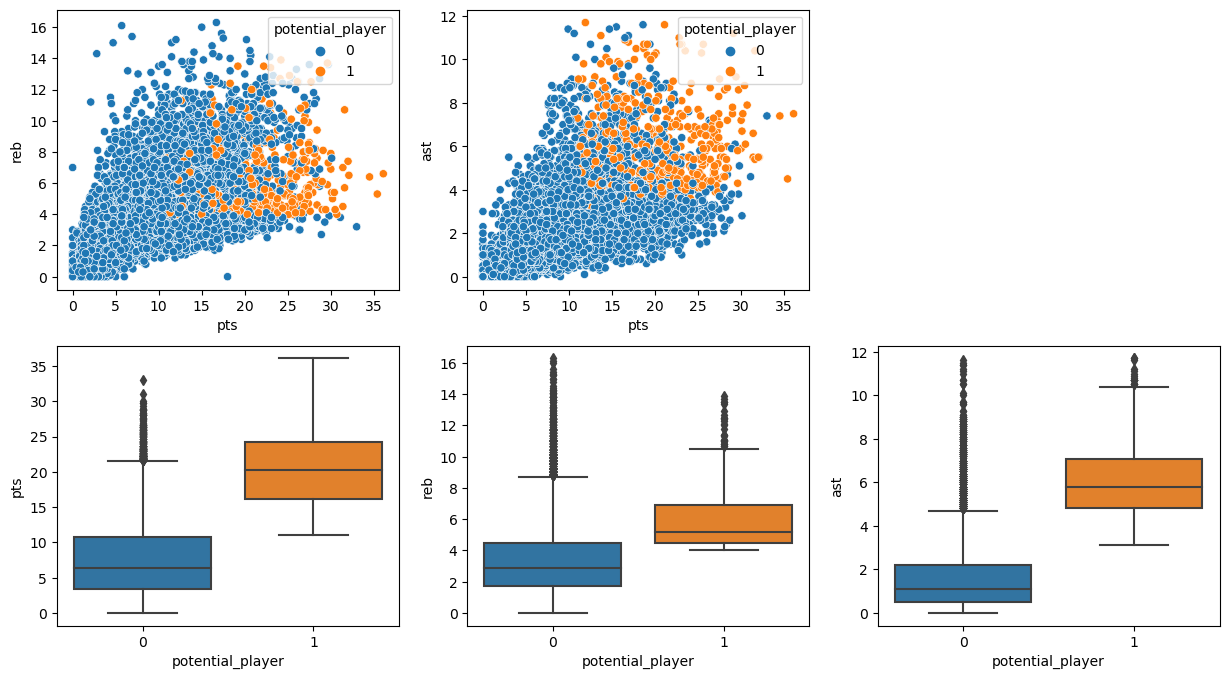

In [249]:
plt.style.use('default')
plt.figure(figsize=(15, 8))

plt.subplot(231)
sns.scatterplot(x=nba_players_cleaned.pts, y=nba_players_cleaned.reb, hue=nba_players_cleaned.potential_player)

plt.subplot(232)
sns.scatterplot(x=nba_players_cleaned.pts, y=nba_players_cleaned.ast, hue=nba_players_cleaned.potential_player)

plt.subplot(234)
sns.boxplot(x=nba_players_cleaned.potential_player, y=nba_players_cleaned.pts)

plt.subplot(235)
sns.boxplot(x=nba_players_cleaned.potential_player, y=nba_players_cleaned.reb)

plt.subplot(236)
sns.boxplot(x=nba_players_cleaned.potential_player, y=nba_players_cleaned.ast)


plt.show()

Berdasarkan Feature `pts`
- pemain potential memiliki rata-rata jumlah points scored di atas (kurang lebih) 10
- pemain dengan rata-rata jumlah points scored di bawah 10 dapat diasumsikan tidak akan terkategori sebagai pemain potensial

Berdasarkan Feature `reb`
- pemain potential memiliki rata-rata jumlah rebound di atas (kurang lebih) 4
- pemain dengan rata-rata jumlah rebound di bawah 4 dapat diasumsikan tidak akan terkategori sebagai pemain potensial

Berdasarkan Feature `ast`
- pemain potential memiliki rata-rata jumlah assists di atas (kurang lebih) 3
- pemain dengan rata-rata jumlah assists di bawah 4 dapat diasumsikan tidak akan terkategori sebagai pemain potensial

Namun di satu sisi belum tentu pemain dengan jumlah score, rebound dan assists tinggi secara otomatis terkategori sebagai pemain potensial karena masih ada faktor lain seperti tinggi, berat, usia dan lain-lain yang kemungkinan berpengaruh

### C.4) Pengaruh tinggi dan berat pemain terhadap label potential_player

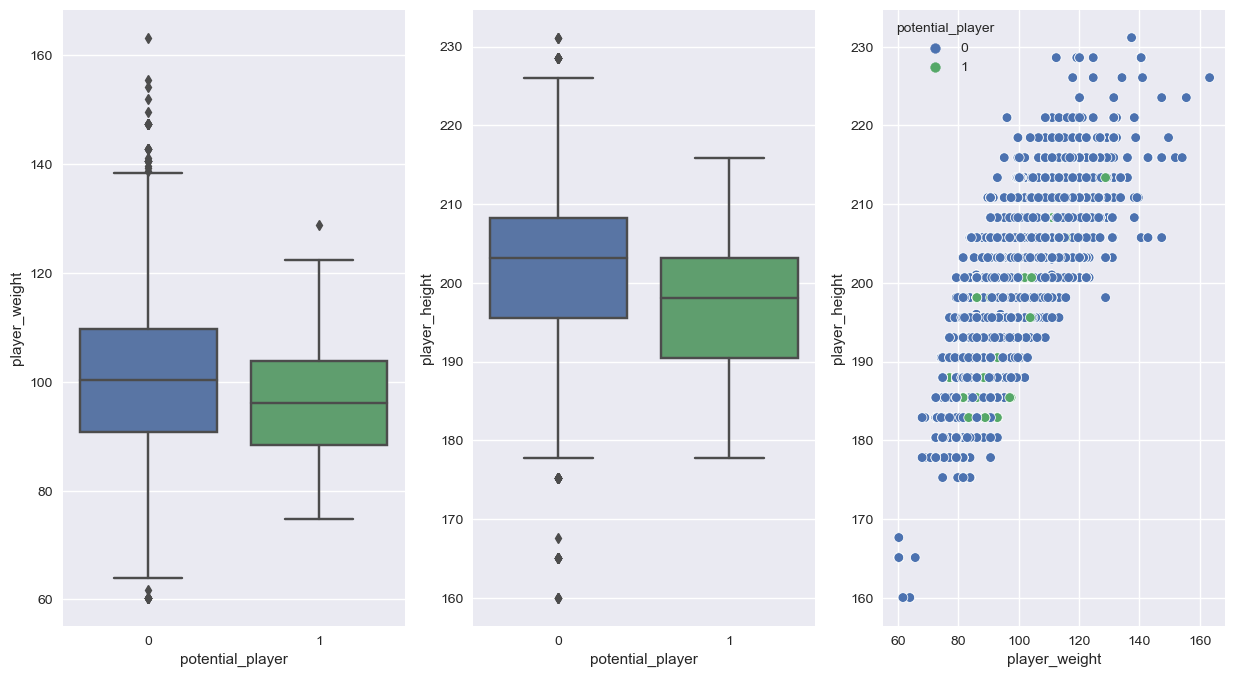

In [107]:
plt.style.use('seaborn')
plt.figure(figsize=(15, 8))

plt.subplot(131)
sns.boxplot(x=nba_players_cleaned.potential_player, y=nba_players_cleaned.player_weight)

plt.subplot(132)
sns.boxplot(x=nba_players_cleaned.potential_player, y=nba_players_cleaned.player_height)

plt.subplot(133)
sns.scatterplot(x=nba_players_cleaned.player_weight, y=nba_players_cleaned.player_height, hue=nba_players_cleaned.potential_player)

plt.show()

Berdasarkan Feature `player_weight`
- berat badan pemain potensial cenderung berada di kisaran sekitar 70 hingga 125 dimana hanya terdapat 1 pemain dengan berat badan di atas 125. Sedangkan untuk pemain non-potential kisarannya hampir sama dengan pemain potensial namun ada lebih banyak pemain yang memiliki berat badan di luar batas normal pemain lainnya.
- untuk sementara ini kita bisa berasumsi bahwa sebagian besar pemain potential memiliki berat badan dalam batas normal.

Berdasarkan Feature `player_height`
- tinggi badan pemain potential cenderung berada di kisaran sekitar 178 hingga 215. Dari data ini, kita bisa melihat bahwa data tinggi badan pemain potensial stabil berada dikisaran rentang tersebut. Kita juga bisa melihat bahwa para pemain potential tidak lebih rendah dari tinggi 188.
- pemain non-potensial ternyata ada yang memiliki badan lebih tinggi namun tidak terkategori sebagai pemain potensial. Untuk sementara ini kita bisa berasumsi bahwa tinggi badan yang terlalu tinggi tidak menjamin pemain tersebut terkategori sebagai pemain potensial

Berdasarkan scatterplot di chart bagian paling kiri, kita sekali bisa melihat bahwa para pemain potential memiliki tinggi dan berat badan yang wajar. Ada petunjuk bahwa para pemain potential paling tidak memiliki tinggi minimal 178 dan berat badan di kisaran 70-125. Namun belum ada petunjuk yang mengindikasikan bahwa pemain dengan badan lebih tinggi akan otomatis menjadi pemain potential.

### C.5) Top-15 College yang banyak mencetak pemain potential

In [116]:
temp_college = nba_players_cleaned[nba_players_cleaned['potential_player'] == 1][['player_name', 'country', 'college', 'potential_player']]
temp_college.drop_duplicates(['player_name'], inplace=True)
temp_college

,player_name,country,college,potential_player
36,Detlef Schrempf,USA,Washington,1
85,Gary Payton,USA,Oregon State,1
107,Grant Hill,USA,Duke,1
147,Allen Iverson,USA,Georgetown,1
153,Anfernee Hardaway,USA,Memphis,1
...,...,...,...,...
11024,Khris Middleton,USA,Texas A&M,1
11044,Lonzo Ball,USA,UCLA,1
11069,Karl-Anthony Towns,USA,Kentucky,1
11070,Kawhi Leonard,USA,San Diego State,1


In [119]:
temp_college_bar = pd.DataFrame(temp_college.college.value_counts()[:10])
temp_college_bar

,college
None,20
Kentucky,11
UCLA,6
Arizona,6
Wake Forest,4
North Carolina,3
Connecticut,3
Memphis,3
Oklahoma,3
Florida,3


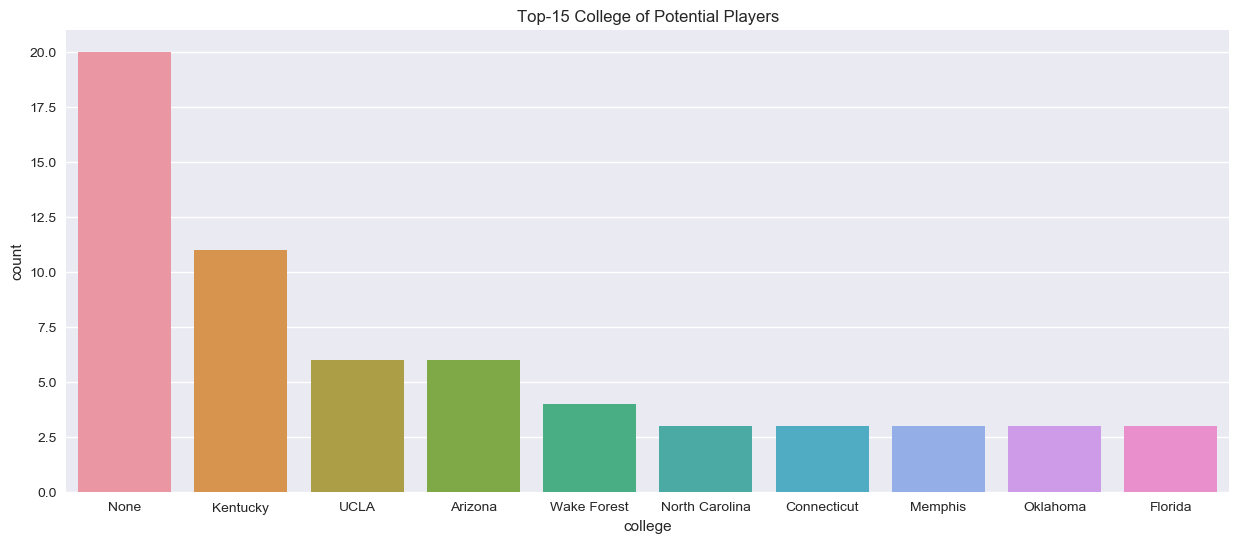

In [125]:
plt.figure(figsize=(15, 6))

sns.barplot(x=temp_college_bar.index, y=temp_college_bar.college)

plt.title('Top-15 College of Potential Players')
plt.xlabel('college')
plt.ylabel('count')

plt.show()

- Mayoritas pemain potential NBA berasal dari Kentucky lalu diikuti oleh UCLA, Arizona, Wake Forest dan 4 college lain dengan jumlah sama yaitu North Carolina, Connecticut, Memphis, Oklahoma, & Florida
- Namun, ada sekitar 20 pemain yang tidak dapat diidentifikasi dari college mana mereka berasal. Ada kemungkinan para pemain ini adalah mereka yang langsung meniti karir profesional setelah lulus High School seperti contohnya Kobe Bryant, LeBron James dan Kevin Garnett (https://www.dbl.id/r/4354/langsung-dari-sma-5-pemain-ini-sukses-di-nba)

#### Pemain potential yang tidak mengikuti pendidikan college
Dalam ini masih ada dua kemungkinan yaitu:
- sebagian tidak mengikuti college
- sebagian datanya tidak terisi sesuai

In [132]:
temp_college[temp_college.college == "None"][['player_name', 'college', 'potential_player']]

,player_name,college,potential_player
329,Toni Kukoc,None,1
1094,Kevin Garnett,None,1
1649,Kobe Bryant,None,1
2138,Tracy McGrady,None,1
3120,LeBron James,None,1
3172,Manu Ginobili,None,1
4086,Pau Gasol,None,1
4257,Boris Diaw,None,1
4260,Andrei Kirilenko,None,1
4976,Hedo Turkoglu,None,1


### C.6) Top-5 Country asal para pemain potential

In [137]:
temp_college_country = pd.DataFrame(temp_college['country'].value_counts())[:10]
temp_college_country

,country
USA,111
Australia,3
Spain,3
France,2
Slovenia,2
Canada,2
Russia,1
Argentina,1
Dominican Republic,1
Croatia,1


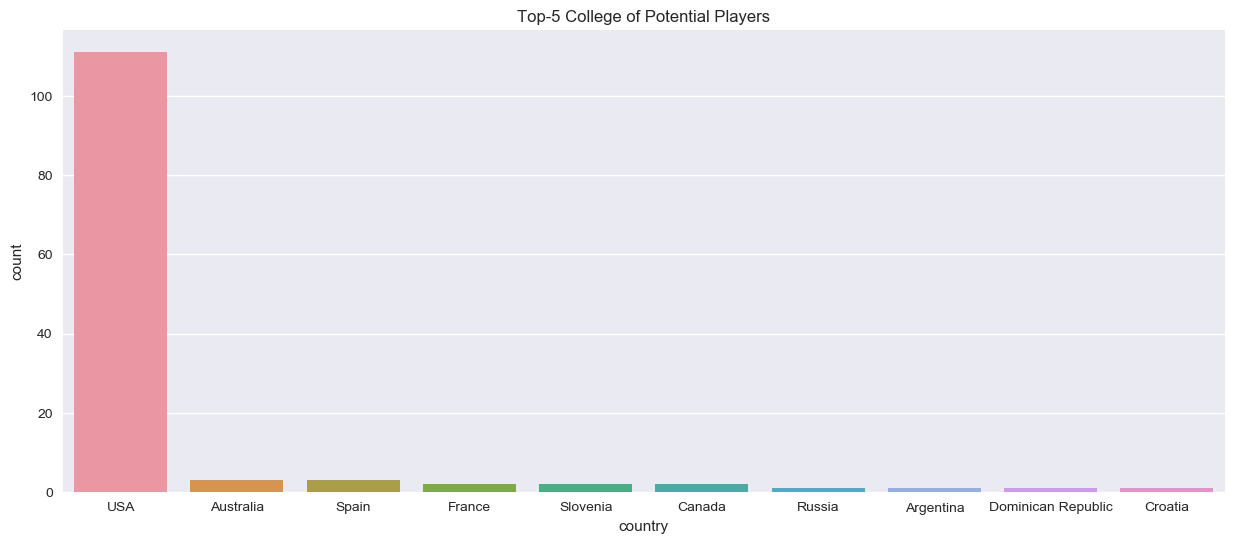

In [139]:
plt.figure(figsize=(15, 6))

sns.barplot(x=temp_college_country.index, y=temp_college_country.country);

plt.title('Top-5 College of Potential Players')
plt.xlabel('country')
plt.ylabel('count')

plt.show()

- para pemain potential di NBA masih didominasi oleh pemain dari USA di mana ada sekitar 100 pemain
- pemain dari negara lain seperti Australia, Spanyol, Prancis dan sebagainya memiliki jumlah pemain yang tidak terlalu banyak berkisar di antara 1-3 dari masing-masing negara

# E) Data Preparation - Soal No. 1 (lanjutan)

In [141]:
nba_players_cleaned.head()

,Unnamed: 0,player_name,age,player_height,player_weight,college,country,gp,pts,reb,ast,net_rating,oreb_pct,dreb_pct,usg_pct,ts_pct,ast_pct,potential_player
0,0,Dennis Rodman,36.0,198.12,99.790240,Southeastern Oklahoma State,USA,55,5.7,16.1,3.1,16.1,0.186,0.323,0.100,0.479,0.113,0
1,1,Dwayne Schintzius,28.0,215.90,117.933920,Florida,USA,15,2.3,1.5,0.3,12.3,0.078,0.151,0.175,0.430,0.048,0
2,2,Earl Cureton,39.0,205.74,95.254320,Detroit Mercy,USA,9,0.8,1.0,0.4,-2.1,0.105,0.102,0.103,0.376,0.148,0
3,3,Ed O'Bannon,24.0,203.20,100.697424,UCLA,USA,64,3.7,2.3,0.6,-8.7,0.060,0.149,0.167,0.399,0.077,0
4,4,Ed Pinckney,34.0,205.74,108.862080,Villanova,USA,27,2.4,2.4,0.2,-11.2,0.109,0.179,0.127,0.611,0.040,0


In [142]:
# drop player_name
nba_players_cleaned_x = nba_players_cleaned.drop('player_name', axis=1)
nba_players_cleaned_x.head()

,Unnamed: 0,age,player_height,player_weight,college,country,gp,pts,reb,ast,net_rating,oreb_pct,dreb_pct,usg_pct,ts_pct,ast_pct,potential_player
0,0,36.0,198.12,99.790240,Southeastern Oklahoma State,USA,55,5.7,16.1,3.1,16.1,0.186,0.323,0.100,0.479,0.113,0
1,1,28.0,215.90,117.933920,Florida,USA,15,2.3,1.5,0.3,12.3,0.078,0.151,0.175,0.430,0.048,0
2,2,39.0,205.74,95.254320,Detroit Mercy,USA,9,0.8,1.0,0.4,-2.1,0.105,0.102,0.103,0.376,0.148,0
3,3,24.0,203.20,100.697424,UCLA,USA,64,3.7,2.3,0.6,-8.7,0.060,0.149,0.167,0.399,0.077,0
4,4,34.0,205.74,108.862080,Villanova,USA,27,2.4,2.4,0.2,-11.2,0.109,0.179,0.127,0.611,0.040,0


Checking the column of nba_players and new_players

In [146]:
print("new_players_cleaned", "; length: ", len(new_players_cleaned))
display(pd.DataFrame(new_players_cleaned.columns).T)
print("nba_players_cleaned_x", "; length: ", len(nba_players_cleaned_x))
display(pd.DataFrame(nba_players_cleaned_x.columns).T)

new_players_cleaned ; length:  500


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,Unnamed: 0,age,player_height,player_weight,college,country,gp,pts,reb,ast,net_rating,oreb_pct,dreb_pct,usg_pct,ts_pct,ast_pct


nba_players_cleaned_x ; length:  11145


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,Unnamed: 0,age,player_height,player_weight,college,country,gp,pts,reb,ast,net_rating,oreb_pct,dreb_pct,usg_pct,ts_pct,ast_pct,potential_player


### E.1) Train Test Split - Soal No. 3

In [188]:
X = nba_players_cleaned_x.drop('potential_player', axis=1)
y = nba_players_cleaned_x['potential_player']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, stratify=y, random_state=2020)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((7801, 16), (3344, 16), (7801,), (3344,))

### E.2) Pipeline/Transformer
1. checking missing values 
    - imputation
1. dropping features
    - nba_players: drop
    - new_players: drop `player_id`
1. encoding
    - binary encoding: `college` & `country`
1. scaling
    - standard scaler: "gp"
    - robust scaler: untuk feature ["pts", "reb", "ast", "net_rating", "oreb_pct", "dreb_pct", "usg_pct", "ts_pct", "ast_pct"]

In [189]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7801 entries, 1924 to 1905
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Unnamed: 0     7801 non-null   int64  
 1   age            7801 non-null   float64
 2   player_height  7801 non-null   float64
 3   player_weight  7801 non-null   float64
 4   college        7801 non-null   object 
 5   country        7801 non-null   object 
 6   gp             7801 non-null   int64  
 7   pts            7801 non-null   float64
 8   reb            7801 non-null   float64
 9   ast            7801 non-null   float64
 10  net_rating     7801 non-null   float64
 11  oreb_pct       7801 non-null   float64
 12  dreb_pct       7801 non-null   float64
 13  usg_pct        7801 non-null   float64
 14  ts_pct         7801 non-null   float64
 15  ast_pct        7801 non-null   float64
dtypes: float64(12), int64(2), object(2)
memory usage: 1.0+ MB


In [191]:
transformer = ColumnTransformer([
    ('binary', ce.BinaryEncoder(), ['college', 'country']),
    ('standard_scaler', StandardScaler(), ['gp']),
    ('robust_scaler', RobustScaler(), ["pts", "reb", "ast", "net_rating", "oreb_pct", "dreb_pct", "usg_pct", "ts_pct", "ast_pct"])
], remainder='passthrough')

In [182]:
# transformer = ColumnTransformer([
#     ('binary', ce.BinaryEncoder(), ['college', 'country']), 
#     ('scaler', StandardScaler(), ['gp', 'pts', 'reb', 'ast', 'net_rating', 'oreb_pct', 'dreb_pct', 'usg_pct', 'ts_pct', 'ast_pct'])
# ], remainder='passthrough')

# F) Modelling - Benchmark - Soal No. 4

### F.1) Define Model and Combine with Pipeline
- mulai membangun model sederhana sebagai benchmark
- machine learning model yang dipakai adalah machine learning untuk classification
    1. Decision Tree
    1. Logistic Regression

In [192]:
dtc = DecisionTreeClassifier()
logreg = LogisticRegression(solver='liblinear')
# knn = KNeighborsClassifier()

# Decision Tree
dtc_pipeline = Pipeline([
    ('transformer', transformer),
    ('clf', dtc)
])

# Logistic Regression
logreg_pipeline = Pipeline([
    ('transformer', transformer),
    ('clf', logreg)
])

# # KNN
# knn_pipeline = Pipeline([
#     ('transformer', transformer),
#     ('clf', knn)
# ])

In [193]:
dtc_pipeline.fit(X_train, y_train)
logreg_pipeline.fit(X_train, y_train)
print('fitting completed')

C:\ProgramData\miniconda3\envs\ml_dl\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
C:\ProgramData\miniconda3\envs\ml_dl\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


fitting completed


#### classification report & confusion matrix Decision Tree

In [194]:
y_pred_dtc = dtc_pipeline.predict(X_test)
print(classification_report(y_test, y_pred_dtc))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3207
           1       0.96      0.98      0.97       137

    accuracy                           1.00      3344
   macro avg       0.98      0.99      0.98      3344
weighted avg       1.00      1.00      1.00      3344



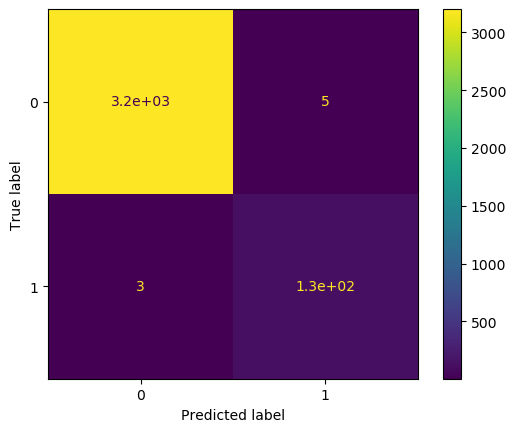

In [197]:
plt.style.use('default')
plot_confusion_matrix(dtc_pipeline, X_test, y_test);

#### classification report & confusion matrix Logistic Regression

In [196]:
y_pred_logreg = logreg_pipeline.predict(X_test)
print(classification_report(y_test, y_pred_logreg))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98      3207
           1       0.71      0.44      0.54       137

    accuracy                           0.97      3344
   macro avg       0.85      0.72      0.76      3344
weighted avg       0.97      0.97      0.97      3344



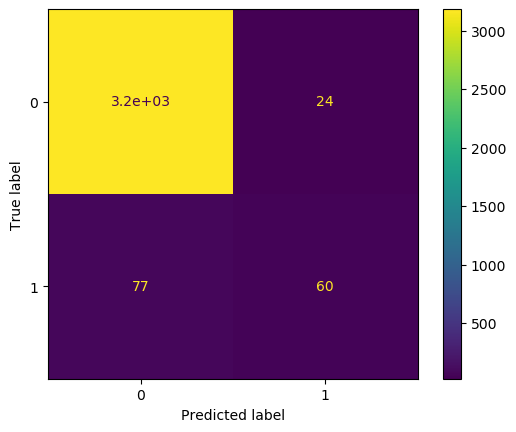

In [198]:
plt.style.use('default')
plot_confusion_matrix(logreg_pipeline, X_test, y_test);

### F.2) Cross Validation Score
- proses cross validation score akan coba dilakukan untuk kedua model pipeline
- score yang akan digunakan adalah `Recall` dengan pertimbangan:
    - tim saat ini sedang dilanda kesulitan keuangan
    - tim rekrutmen harus secara selektif memilih pemain yang benar-benar potensial
    - maka di sini kita mencoba meminimalkan `False Negative` supaya pemain yang potential benar-benar terprediksi dan terekrut sebagai pemain potential

In [184]:
skfold = StratifiedKFold(n_splits=5)

dtc_pipeline_cv = cross_val_score(dtc_pipeline, X_train, y_train, cv=skfold, scoring='recall')
logreg_pipeline_cv = cross_val_score(logreg_pipeline, X_train, y_train, cv=skfold, scoring='recall')
# knn_pipeline_cv = cross_val_score(knn_pipeline, X_train, y_train, cv=skfold, scoring='recall')


print('CV DTC:', dtc_pipeline_cv)
print('CV Logreg:', logreg_pipeline_cv)
# print('CV KNN:', knn_pipeline_cv)

C:\ProgramData\miniconda3\envs\ml_dl\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
C:\ProgramData\miniconda3\envs\ml_dl\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
C:\ProgramData\miniconda3\envs\ml_dl\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
C:\ProgramData\miniconda3\envs\ml_dl\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
C:\ProgramDa

CV DTC: [0.953125   0.96825397 0.96825397 0.96875    0.921875  ]
CV Logreg: [0.53125    0.57142857 0.58730159 0.40625    0.5       ]


In [185]:
# base_models = [("DT_model", DecisionTreeClassifier(random_state = 2020)),
#                ("LR_model", LogisticRegression(solver='liblinear', random_state = 2020))]

# kfolds = 5
# split = KFold(n_splits=kfolds, shuffle=True, random_state=2020)


# for name, model in base_models:
#     model_steps = Pipeline(steps=[('preprocessor', transformer),
#                               ('model', model)])
    
#     # cv score untuk setiap model
#     cv_results = cross_val_score(model_steps, 
#                                  X, y, 
#                                  cv=split,
#                                  scoring="recall",
#                                  n_jobs=-1)
#     # output:
#     results_CV = cv_results
#     print(f"{name}: {results_CV}")

#### plot cross_val_score

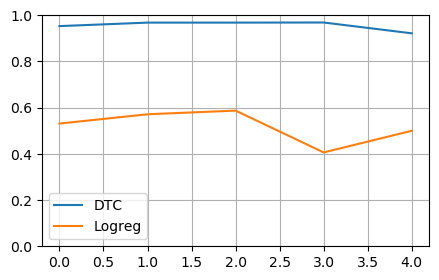

In [187]:
plt.style.use('default')
plt.figure(figsize=(5,3))

plt.plot(range(len(dtc_pipeline_cv)), dtc_pipeline_cv, label='DTC')
plt.plot(range(len(logreg_pipeline_cv)), logreg_pipeline_cv, label='Logreg')
# plt.plot(range(len(knn_pipeline_cv)), knn_pipeline_cv, label='KNN')


plt.ylim(0,1)
plt.grid()
plt.legend()
plt.show()

- dari grafik di atas, terlihat bahwa dari hasil cross validation, model Decision Tree cenderung lebih stabil di kisaran score Recall antara 92 - 97. Model Decision Tree menjadi model yang berpotensi digunakan untuk memprediksi perekrutan pemain baru.
- sedangkan Logistic Regression memiliki performance yang lebih buruk yaitu score Recall antara 40-59
- selanjutnya kita akan mencoba melakukan hyperparameter untuk melihat lebih lanjut kestabilan dan peningkatan dari setial model

# G) Modelling - Hyperparameter Tuning - Soal No. 5
pada proses hyperparameter tuning akan ditambahkan poin-poin berikut:

1. Decision Tree
    - memakai feature selection RFE
    - memakai class_weight = 'balanced' untuk menghandle isu imbalanced data
1. Logistic Regression
    - memakai class_weight = 'balanced' untuk menghandle isu imbalanced data

### G.1) Decision Tree

In [199]:
dtc_hyper = DecisionTreeClassifier()
rfe = RFE(estimator=dtc_hyper)

dtc_pipeline_hyper = Pipeline([
    ('transformer', transformer),
    ('rfe', rfe),
    ('clf', dtc_hyper)
])

In [200]:
hyperparam_space = {
    'clf__criterion': ['gini', 'entropy'],
    'clf__max_depth': [5,10,15,20],
    'clf__min_samples_split': [5,6,7,8]
}

grid_search_dtc_hyper = GridSearchCV(
    dtc_pipeline_hyper,
    param_grid = hyperparam_space,
    cv = skfold,
    scoring = 'recall',
    n_jobs = -1,
    verbose = 1
)

In [201]:
grid_search_dtc_hyper.fit(X_train, y_train)

Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   16.7s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:   46.9s finished
C:\ProgramData\miniconda3\envs\ml_dl\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('transformer',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='passthrough',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('binary',
                                                                         BinaryEncoder(cols=None,
                                                                                       drop_invariant=False,
                                                                                       handle_missing='value',
                                                                        

In [202]:
print('estimator dtc tuned score:', grid_search_dtc_hyper.best_score_)
print('estimator dtc best params:', grid_search_dtc_hyper.best_params_)

estimator dtc tuned score: 0.9905753968253969
estimator dtc best params: {'clf__criterion': 'entropy', 'clf__max_depth': 5, 'clf__min_samples_split': 6}


#### classification report & confusion matrix Decision Tree

In [203]:
y_pred_dtc_hyper = grid_search_dtc_hyper.predict(X_test)
print(classification_report(y_test, y_pred_dtc_hyper))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3207
           1       0.98      0.98      0.98       137

    accuracy                           1.00      3344
   macro avg       0.99      0.99      0.99      3344
weighted avg       1.00      1.00      1.00      3344



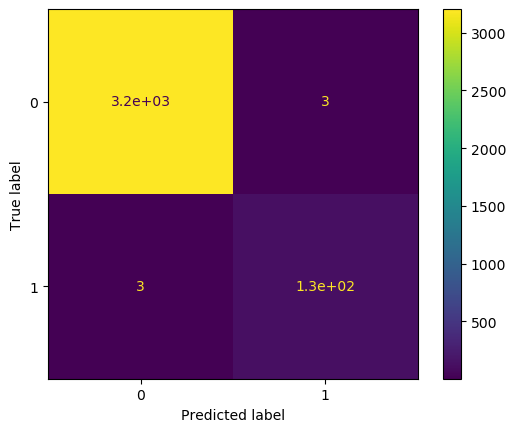

In [204]:
plt.style.use('default')
plot_confusion_matrix(grid_search_dtc_hyper, X_test, y_test);

### G.2) Logistic Regression

In [205]:
logreg_hyper = LogisticRegression(solver='liblinear', class_weight='balanced')

logreg_pipeline_hyper = Pipeline([
    ('transformer', transformer),
    ('clf', logreg_hyper)
])

In [208]:
hyperparam_space_logreg = {
    'clf__C':[1000, 500, 100, 50, 10, 5, 1, 0.5, 0.1, 0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001], # benck mark 1 C = 1 bench mark 2 C = 0.05
    'clf__max_iter':[100, 200, 300, 400, 500, 1000], # bench mark max_iter = 100
}

grid_search_logreg_hyper = GridSearchCV(
    logreg_pipeline_hyper,
    param_grid = hyperparam_space_logreg,
    cv = skfold,
    scoring = 'recall',
    verbose = 1,
    n_jobs = -1
)

In [209]:
grid_search_logreg_hyper.fit(X_train, y_train)

Fitting 5 folds for each of 90 candidates, totalling 450 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   26.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 450 out of 450 | elapsed:  1.6min finished
C:\ProgramData\miniconda3\envs\ml_dl\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('transformer',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='passthrough',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('binary',
                                                                         BinaryEncoder(cols=None,
                                                                                       drop_invariant=False,
                                                                                       handle_missing='value',
                                                                        

In [215]:
print('estimator logreg tuned score:', grid_search_logreg_hyper.best_score_)
print('estimator logreg best params:', grid_search_logreg_hyper.best_params_)

estimator logreg tuned score: 0.9749503968253969
estimator logreg best params: {'clf__C': 0.0005, 'clf__max_iter': 100}


#### classification report & confusion matrix Logistic Regression

In [211]:
y_pred_logreg_hyper = grid_search_logreg_hyper.predict(X_test)
print(classification_report(y_test, y_pred_logreg_hyper))

              precision    recall  f1-score   support

           0       1.00      0.91      0.95      3207
           1       0.32      0.98      0.48       137

    accuracy                           0.91      3344
   macro avg       0.66      0.94      0.72      3344
weighted avg       0.97      0.91      0.93      3344



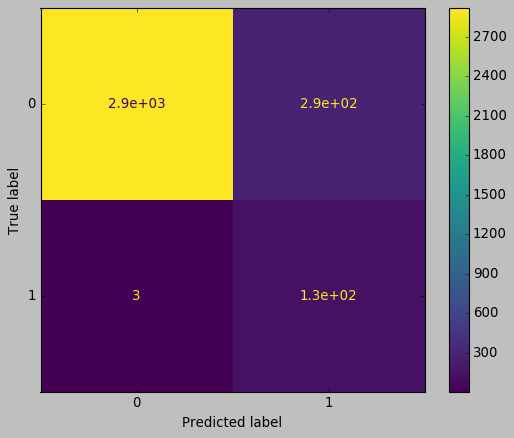

In [213]:
plt.style.use('classic')
plot_confusion_matrix(grid_search_logreg_hyper, X_test, y_test);

- hyperparameter tuning process membuat model meningkat
    - Decision Tree
        1. pada benchmark model kita mendapati kisaran score CV DTC: [0.953125   0.96825397 0.96825397 0.96875    0.921875  ]
        2. pada model yang sudah dikenai proses hyperparameter tuning, hasilnya meningkat sekitar 0.3 sbb:
            - estimator dtc tuned score: 0.9905753968253969
            - estimator dtc best params: {'clf__criterion': 'entropy', 'clf__max_depth': 5, 'clf__min_samples_split': 6}
        3. ini menunjukkan ada model baru hasil hyperparameter tuning mengalami kenaikan
    - Logistic Regression
        1. pada benchmark model kita mendapati kisaran score CV Logreg: [0.53125    0.57142857 0.58730159 0.40625    0.5       ]
        2. pada model yang sudah dikenai proses hyperparameter tuning, hasilnya meningkat sekitar 41 sbb:
            - estimator logreg tuned score: 0.9749503968253969
            - estimator logreg best params: {'clf__C': 0.0005, 'clf__max_iter': 100}
        3. ini menunjukkan ada model baru hasil hyperparameter tuning mengalami kenaikan yang signifikan terutama setelah ada treatment khusus untuk menangani imbalance dataset yaitu dengan ditambahkan `class_weight='balanced'`
        
- pada akhirnya hasil k dengan melihat best score terbaru dari kedua model tersebut, diputuskan untuk menggunakan machine learning model **Decision Tree with Hyperparameter Tuning** => `grid_search_dtc_hyper`

# H) Prediction - Recruitment Process - Soal No. 6

In [214]:
new_players_cleaned.head()

,Unnamed: 0,age,player_height,player_weight,college,country,gp,pts,reb,ast,net_rating,oreb_pct,dreb_pct,usg_pct,ts_pct,ast_pct
0,0,37.0,205.74,104.326160,Texas Christian,USA,70,3.0,4.2,0.7,-5.2,0.084,0.237,0.114,0.489,0.069
1,1,33.0,160.02,63.956472,Wake Forest,USA,61,5.7,2.2,5.4,-8.4,0.020,0.074,0.129,0.492,0.344
2,2,27.0,193.04,95.254320,Indiana,USA,36,18.8,5.6,5.2,5.6,0.018,0.154,0.278,0.519,0.250
3,3,21.0,195.58,99.790240,Cincinnati,USA,42,2.5,1.3,1.1,-4.2,0.030,0.115,0.171,0.400,0.174
4,4,23.0,215.90,122.469840,None,USA,26,3.3,3.4,0.3,-7.8,0.069,0.221,0.112,0.551,0.037


In [216]:
prediction = grid_search_dtc_hyper.predict(new_players_cleaned)
prediction

array([0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

#### convert to dataframe

In [217]:
recruitment_result = pd.DataFrame({'id': new_players_cleaned.index, 'potential_player': prediction})
recruitment_result

,id,potential_player
0,0,0
1,1,0
2,2,1
3,3,0
4,4,0
...,...,...
495,495,0
496,496,0
497,497,0
498,498,0


In [250]:
new_players['potential_player'] = prediction
new_players

,Unnamed: 0,player_id,age,player_height,player_weight,college,country,gp,pts,reb,ast,net_rating,oreb_pct,dreb_pct,usg_pct,ts_pct,ast_pct,potential_player
0,0,1,37.0,205.74,104.326160,Texas Christian,USA,70,3.0,4.2,0.7,-5.2,0.084,0.237,0.114,0.489,0.069,0
1,1,2,33.0,160.02,63.956472,Wake Forest,USA,61,5.7,2.2,5.4,-8.4,0.020,0.074,0.129,0.492,0.344,0
2,2,3,27.0,193.04,95.254320,Indiana,USA,36,18.8,5.6,5.2,5.6,0.018,0.154,0.278,0.519,0.250,1
3,3,4,21.0,195.58,99.790240,Cincinnati,USA,42,2.5,1.3,1.1,-4.2,0.030,0.115,0.171,0.400,0.174,0
4,4,5,23.0,215.90,122.469840,None,USA,26,3.3,3.4,0.3,-7.8,0.069,0.221,0.112,0.551,0.037,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,495,496,28.0,200.66,103.418976,Nevada-Las Vegas,USA,81,21.8,11.8,1.8,7.1,0.086,0.238,0.222,0.591,0.068,0
496,496,497,28.0,200.66,107.047712,California,USA,78,12.8,4.4,1.6,-4.9,0.054,0.124,0.233,0.490,0.099,0
497,497,498,23.0,208.28,103.418976,Wisconsin,USA,46,4.7,2.6,0.5,0.2,0.087,0.162,0.174,0.536,0.072,0
498,498,499,24.0,213.36,108.862080,DePaul,USA,69,6.1,3.9,0.2,-1.7,0.099,0.140,0.146,0.598,0.021,0


#### hasil recruitment

In [219]:
recruitment_result_bar = pd.DataFrame(recruitment_result.potential_player.value_counts())
recruitment_result_bar

,potential_player
0,483
1,17


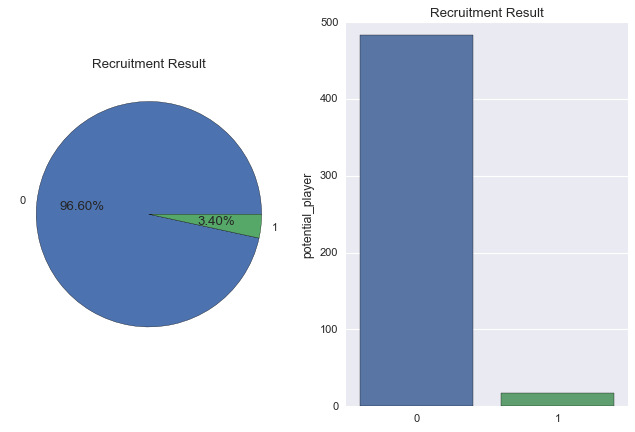

In [232]:
plt.style.use('seaborn')
fig = plt.figure(figsize=(10,6))


plt.subplot(121)
plt.pie(recruitment_result_bar['potential_player'], labels=recruitment_result_bar.index, autopct=lambda p:f'{p:.2f}%')
plt.title('Recruitment Result')

plt.subplot(122)
sns.barplot(x=[0, 1], y=recruitment_result_bar.potential_player)
plt.title('Recruitment Result')

plt.show()

- dari 500 pemain baru, 17 pemain berhasil diprediksi sebagai pemain potential berdasarkan model yang telah dibangun
- mengingat target manager tim adalah merekrut 10 pemain baru, maka daftar 17 pemain ini dapat menjadi saringan awal untuk seleksi lanjutan hingga berhasil dipilih 10 pemain potensial yang dapat memberikan kontribusi lebih baik bagi tim basket ke depannya.

# End of Analysis & Model Development